What I have and had done:
1. Given the very less number of examples, training a classification model from scratch will only take us so far. So, I have opted to use transfer learning approach.
2. I have also tried transfer learning with VGG-16. I couldn't get fbeta score of above 0.914 with that architecture. Transfer learning because the dataset is so small(only 1,098 train examples.)
3. I had tried batch sizes from 4 to 64 and it's batch size of 16, that worked.

And yes, I have removed all the cells in this notebook that I tried above things in, for better understanding.

# loading and preparing data

In [1]:
# kaggle paths
TRAIN_DATA_DIR = "../input/10-monkey-species/training/training/"
VALID_DATA_DIR = "../input/10-monkey-species/validation/validation/"
LABELS_FILE = "../input/10-monkey-species/monkey_labels.txt"
FILE_SAVE_PATH = "/kaggle/working/"

In [2]:
import os
import numpy as np
# set the seed for to make results reproducable
np.random.seed(2)
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')


from tensorflow.random import set_seed
# set the seed for to make results reproducable
set_seed(2)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
img_width = 224  # since this is the size of image, that vgg19 model, as the documentation states, accepts
img_height = 224 # check: https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19#arguments_1
btch_size = 16   # since the dataset is small

In [4]:
# Since the number of example is very low, I am making some augmentation in the training data(not increasing the count of training examples),
# to make the robust to the unseen examples.
train_data_IDG = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                    zoom_range=0.2, fill_mode='nearest', horizontal_flip=True, rescale=1.0/255,
                                    validation_split=0.0)

valid_data_IDG = ImageDataGenerator(rescale=1.0/255)

In [5]:
train_data_generator = train_data_IDG.flow_from_directory(directory=TRAIN_DATA_DIR, target_size=(img_width, img_height),
                                                          class_mode='categorical', batch_size=btch_size)

valid_data_generator = valid_data_IDG.flow_from_directory(directory=VALID_DATA_DIR, target_size=(img_width, img_height),
                                                          class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [6]:
train_len = 1_098
valid_len = 272

## exploring data

In [7]:
tr_imgs, tr_labels = train_data_generator.next()
tr_imgs.shape, tr_labels.shape

((16, 224, 224, 3), (16, 10))

In [8]:
target_data = pd.read_csv(filepath_or_buffer=LABELS_FILE)
target_data

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


 japanese_macaque              


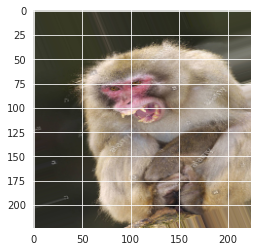

In [9]:
i = 2
print(target_data.iloc[np.where(tr_labels[i] == 1)[0][0], 2])
plt.imshow(tr_imgs[i])

 japanese_macaque              


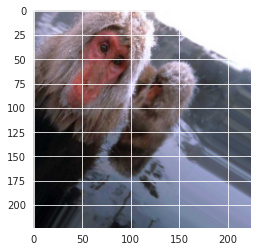

In [10]:
i = 7
print(target_data.iloc[np.where(tr_labels[i] == 1)[0][0], 2])
plt.imshow(tr_imgs[i])

### checking balance in the output classes

In [11]:
labels = train_data_generator.classes
labels.shape

(1098,)

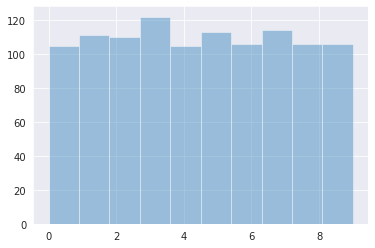

In [12]:
sns.distplot(a=labels, bins=None, kde=False)

looks quiet balanced. Also look at the percentage of examples available per class.

In [13]:
pd.Series(labels).value_counts(normalize=True)

3    0.111111
7    0.103825
5    0.102914
1    0.101093
2    0.100182
9    0.096539
8    0.096539
6    0.096539
4    0.095628
0    0.095628
dtype: float64

# modelling

## VGG-19

### making model

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19


from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers

In [15]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='max')


# # let's make some layers at the last layers non-trainable, since that's where I want to make changes at
for layer in base_model.layers[:-6]:
    layer.trainable = False

# checking the status in number of parameters trainable
base_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [16]:
for layer in base_model.layers[:]:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc4e8eacf50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8ed6510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8ed6c50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4e8e88450> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8bea510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8bea5d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4e8c0c150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8c11190> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8c0c8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8ed6850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4e8b94a90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 

In [17]:
model_vgg19 = Sequential()

for layer in base_model.layers:
    model_vgg19.add(layer)

model_vgg19.add(layers.Dense(512, activation="relu"))
model_vgg19.add(layers.Dropout(0.5))
model_vgg19.add(layers.Dense(10, activation="softmax"))

model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [18]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# saving model weights at the end of every epoch, in case something happens to my internet connection; and so i can resume training with those weights from the epoch last session stopped at.
model_save_cb = ModelCheckpoint(filepath=os.path.join(FILE_SAVE_PATH, 'vgg19-weights-epoch{epoch:02d}-val_fbeta_score{val_fbeta_score:.2f}.h5'))

# let's not waste resources for performance that we aren't gonna get
early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

# also reducing learning rate, because you know all about the gradient reaching optima in correct way.
reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)

# to see how much time each epoch took to complete training
epoch_times_cb = EpochTimeHistory()

In [20]:
from tensorflow_addons.metrics import FBetaScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
# from tensorflow.keras.losses import CategoricalCrossentropy


model_vgg19.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001),
                metrics = [FBetaScore(num_classes=10, average='macro', name='fbeta_score'),
                           CategoricalAccuracy(name='cat_acc'),
                           Precision(name='precision'), Recall(name='recall')])

In [21]:
history_VGG19 = model_vgg19.fit(train_data_generator,
                                  steps_per_epoch=train_len // btch_size,
                                  validation_data=valid_data_generator,
                                  validation_steps=valid_len // btch_size,
                                  epochs=35, verbose=1,
                                  callbacks=[model_save_cb, early_stop_cb,
                                             epoch_times_cb, reduce_learning_rate_cb])

Epoch 1/35
68/68 [==============================] - ETA: 0s - loss: 2.2196 - fbeta_score: 0.2069 - cat_acc: 0.2116 - precision: 0.6182 - recall: 0.0314 ;validation took 0.1509 minutes.
 ;epoch 1 took 0.9518 minutes.
68/68 [==============================] - 52s 758ms/step - loss: 2.2196 - fbeta_score: 0.2069 - cat_acc: 0.2116 - precision: 0.6182 - recall: 0.0314 - val_loss: 1.5091 - val_fbeta_score: 0.4346 - val_cat_acc: 0.4816 - val_precision: 0.7667 - val_recall: 0.1691 - lr: 1.0000e-04
Epoch 2/35
68/68 [==============================] - ETA: 0s - loss: 1.3546 - fbeta_score: 0.5393 - cat_acc: 0.5407 - precision: 0.7376 - recall: 0.3429 ;validation took 0.122 minutes.
 ;epoch 2 took 0.7939 minutes.
68/68 [==============================] - 47s 695ms/step - loss: 1.3546 - fbeta_score: 0.5393 - cat_acc: 0.5407 - precision: 0.7376 - recall: 0.3429 - val_loss: 1.0034 - val_fbeta_score: 0.6817 - val_cat_acc: 0.6765 - val_precision: 0.7667 - val_recall: 0.5074 - lr: 1.0000e-04
Epoch 3/35
68/6

In [22]:
model_vgg19.save(filepath=FILE_SAVE_PATH, overwrite=True, include_optimizer=True)

In [23]:
# if training had no problems, delete all the saved weights and include the final model
!rm /kaggle/working/*.h5

### plotting model statistics

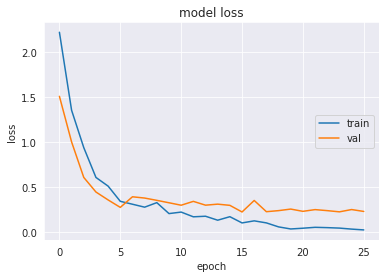

In [24]:
plt.plot(history_VGG19.history['loss'])
plt.plot(history_VGG19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')
plt.show()

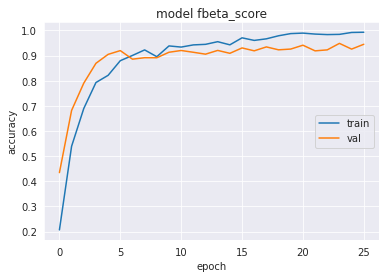

In [25]:
plt.plot(history_VGG19.history['fbeta_score'])
plt.plot(history_VGG19.history['val_fbeta_score'])
plt.title('model fbeta_score')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')
plt.show()

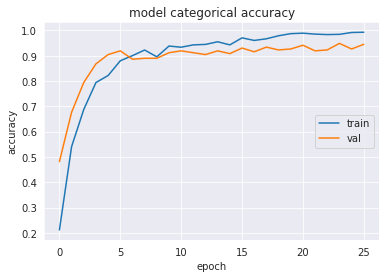

In [26]:
plt.plot(history_VGG19.history['cat_acc'])
plt.plot(history_VGG19.history['val_cat_acc'])
plt.title('model categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')
plt.show()

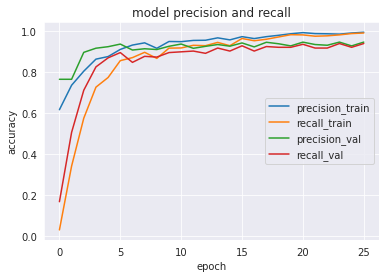

In [27]:
plt.plot(history_VGG19.history['precision'])
plt.plot(history_VGG19.history['recall'])
plt.plot(history_VGG19.history['val_precision'])
plt.plot(history_VGG19.history['val_recall'])
plt.title('model precision and recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train', 'precision_val', 'recall_val'], loc='center right')
plt.show()